In [1]:
import datetime
import backtrader as bt
import pandas as pd
import calendar
from datetime import datetime
import empyrical as ep
import pyfolio as pf
import warnings
warnings.filterwarnings('ignore')

/opt/homebrew/Caskroom/miniforge/base/envs/stock/lib/python3.13/site-packages/pyfolio/pos.py:25: UserWarning: Module "zipline.assets" not found; multipliers will not be applied to position notionals.
  warnings.warn(


In [2]:
def option_expiration(date):
    day = 21 - (calendar.weekday(date.year, date.month, 1) + 4) % 7
    return datetime(date.year, date.month, day)  # type: ignore

In [3]:

class MA_Volume_Strategy(bt.Strategy):
    params = (
        ('ma_short', 3),
        ('ma_medium', 20),
        ('ma_long', 60),
        ('stop_loss_pct', 0.02),
        ('take_profit_pct', 0.02),
    )

    def log(self, txt, dt=None):
        """ 日誌記錄函數 """
        dt = dt or self.datas[0].datetime.datetime(0)
        print(f'{dt.isoformat()}, {txt}')

    def __init__(self):
        # 收盤價
        self.dataclose = self.datas[0].close

        # 成交量
        self.datavolume = self.datas[0].volume

        # 移動平均線
        self.ma_short = bt.indicators.SMA(self.dataclose, period=self.params.ma_short)
        self.ma_medium = bt.indicators.SMA(self.dataclose, period=self.params.ma_medium)
        self.ma_long = bt.indicators.SMA(self.dataclose, period=self.params.ma_long)

        # 成交量移動平均線
        self.vol_ma_short = bt.indicators.SMA(self.datavolume, period=self.params.ma_short)
        self.vol_ma_long = bt.indicators.SMA(self.datavolume, period=self.params.ma_long)

        self.order = None

    def notify_order(self, order):
        if order.status in [order.Submitted, order.Accepted]:
            return 
        
        if order.status in [order.Completed]:
            if order.isbuy():
                self.log(f"""BUY EXECUTED, Price: {order.executed.price:.2f},
                         Cost: {order.executed.value:.2f},
                         Comm: {order.executed.comm:.2f}""")
                self.buycomm = order.executed.comm
            else:
                self.sellprice = order.executed.price
                self.log(f"""SELL EXECUTED, Price: {order.executed.price:.2f},
                         Cost: {order.executed.value:.2f},
                         Comm: {order.executed.comm:.2f}""")
            self.bar_executed = len(self)
        self.order = None

    def notify_trader(self, trade):
        if not trade.isclosed:
            return 
        self.log(f"OPERATION PROFIT, GROSS{trade.pnl:.2f}, NET{trade.pnlcomm:.2f}")

    def next(self):
        if self.order:
            return 
        
        position_size = self.getposition().size
        position_price = self.getposition().price

        status = None
        if (
            option_expiration(self.datas[0].datetime.datetime(0)).day
            == self.datas[0].datetime.datetime(0).day
        ):
            if self.datas[0].datetime.datetime(0).hour >= 13:
                status = "end"
                if position_size != 0:
                    self.close()
                    self.log("Expired and Create CLose Order (結算時間到 -> 平倉)")
                
        if status != "end":
            if not position_size:
                # 多頭進場條件
                if (self.dataclose[0] > self.ma_short[0] and 
                    self.dataclose[0] > self.ma_medium[0] and
                    self.dataclose[0] > self.ma_long[0] and 
                    self.vol_ma_short[0] > self.vol_ma_long[0]):
                    self.order = self.buy()
                    self.log("創建買單")
                # 空頭進場條件
                elif (self.dataclose[0] < self.ma_short[0] and 
                      self.dataclose[0] < self.ma_medium[0] and 
                      self.dataclose[0] < self.ma_long[0] and 
                      self.vol_ma_short[0] < self.vol_ma_long[0]):
                    self.order = self.sell()
                    self.log("創建賣單")
            else:
                # 已有持倉，檢查處場條件
                if position_size > 0:
                    stop_loss_price = position_price * (1 - self.params.stop_loss_pct) # type: ignore
                    take_profit_price = position_price * (1 + self.params.take_profit_pct) # type: ignore
                    # 多頭持倉
                    if self.dataclose[0] >= take_profit_price:
                        self.order = self.close()
                        self.log('平多單 - 停利')
                    elif self.dataclose[0] <= stop_loss_price:
                        self.order = self.close()
                        self.log('平多單 - 止損')
                elif position_size < 0:
                    stop_loss_price = position_price * (1 + self.params.stop_loss_pct) # type: ignore
                    take_profit_price = position_price * (1 - self.params.take_profit_pct) # type: ignore
                    # 空頭持倉
                    if self.dataclose[0] <= take_profit_price:
                        self.order = self.close()
                        self.log('平空單 - 停利')
                    elif self.dataclose[0] >= stop_loss_price:
                        self.order = self.close()
                        self.log('平空單 - 停損')


In [4]:
# 初始化 Cerebro 引擎
cerebro = bt.Cerebro()
df = pd.read_csv('TXF_30.csv')
df = df.dropna()
df['Date'] = pd.to_datetime(df['Date'])
df.index = df['Date']
df = df.between_time('08:45', '13:45')
data_feed = bt.feeds.PandasData(
    dataname=df,
    name="TXF",
    datetime=0,
    high=2,
    low=3,
    open=1,
    close=4,
    volume=5,
    plot=False,
)
cerebro.adddata(data_feed, name='TXF')


In [5]:
# 新增策略
cerebro.addstrategy(MA_Volume_Strategy)

# 設定初始資金和交易成本
cerebro.broker.setcash(300000.0)
cerebro.broker.setcommission(commission=200, margin=167000, mult=200)

print('初始資產價值: %.2f' % cerebro.broker.getvalue())
cerebro.addanalyzer(bt.analyzers.PyFolio, _name='pyfolio')

初始資產價值: 300000.00


In [6]:
# 執行回測
results = cerebro.run()

print('最終資產價值: %.2f' % cerebro.broker.getvalue())

2019-03-12T09:15:00, 創建買單
2019-03-12T09:45:00, BUY EXECUTED, Price: 10322.00,
                         Cost: 167000.00,
                         Comm: 200.00
2019-03-20T13:15:00, Expired and Create CLose Order (結算時間到 -> 平倉)
2019-03-20T13:45:00, SELL EXECUTED, Price: 10543.00,
                         Cost: 167000.00,
                         Comm: 200.00
2019-03-21T09:15:00, 創建買單
2019-03-21T09:45:00, BUY EXECUTED, Price: 10550.00,
                         Cost: 167000.00,
                         Comm: 200.00
2019-04-08T09:45:00, 平多單 - 停利
2019-04-08T10:15:00, SELL EXECUTED, Price: 10785.00,
                         Cost: 167000.00,
                         Comm: 200.00
2019-04-08T10:15:00, 創建買單
2019-04-08T10:45:00, BUY EXECUTED, Price: 10772.00,
                         Cost: 167000.00,
                         Comm: 200.00
2019-04-17T10:45:00, 平多單 - 停利
2019-04-17T11:15:00, SELL EXECUTED, Price: 10990.00,
                         Cost: 167000.00,
                         Comm: 200.00
2

In [7]:
# 取得回測結果
strat = results[0]
pyfoliozer = strat.analyzers.getbyname('pyfolio')
returns, positions, transactions, gross_lev = pyfoliozer.get_pf_items()


Start date,2019-03-04
End date,2020-02-27
Total months,11
,Backtest
Annual return,185.292%
Cumulative returns,173.667%
Annual volatility,50.474%
Sharpe ratio,2.33
Calmar ratio,7.57
Stability,0.90
Max drawdown,-24.473%


Worst drawdown periods,Net drawdown in %,Peak date,Valley date,Recovery date,Duration
0,24.47,2019-08-15,2019-09-03,2019-10-24,51
1,17.49,2019-06-26,2019-07-25,2019-08-05,29
2,15.49,2019-05-03,2019-05-09,2019-05-23,15
3,12.76,2019-05-29,2019-06-06,2019-06-19,16
4,10.25,2020-01-08,2020-01-14,2020-01-30,17


累積收益: 1.7366666666666686
最大回撤: -0.2447257383966245
夏普比率: 2.329928457356796


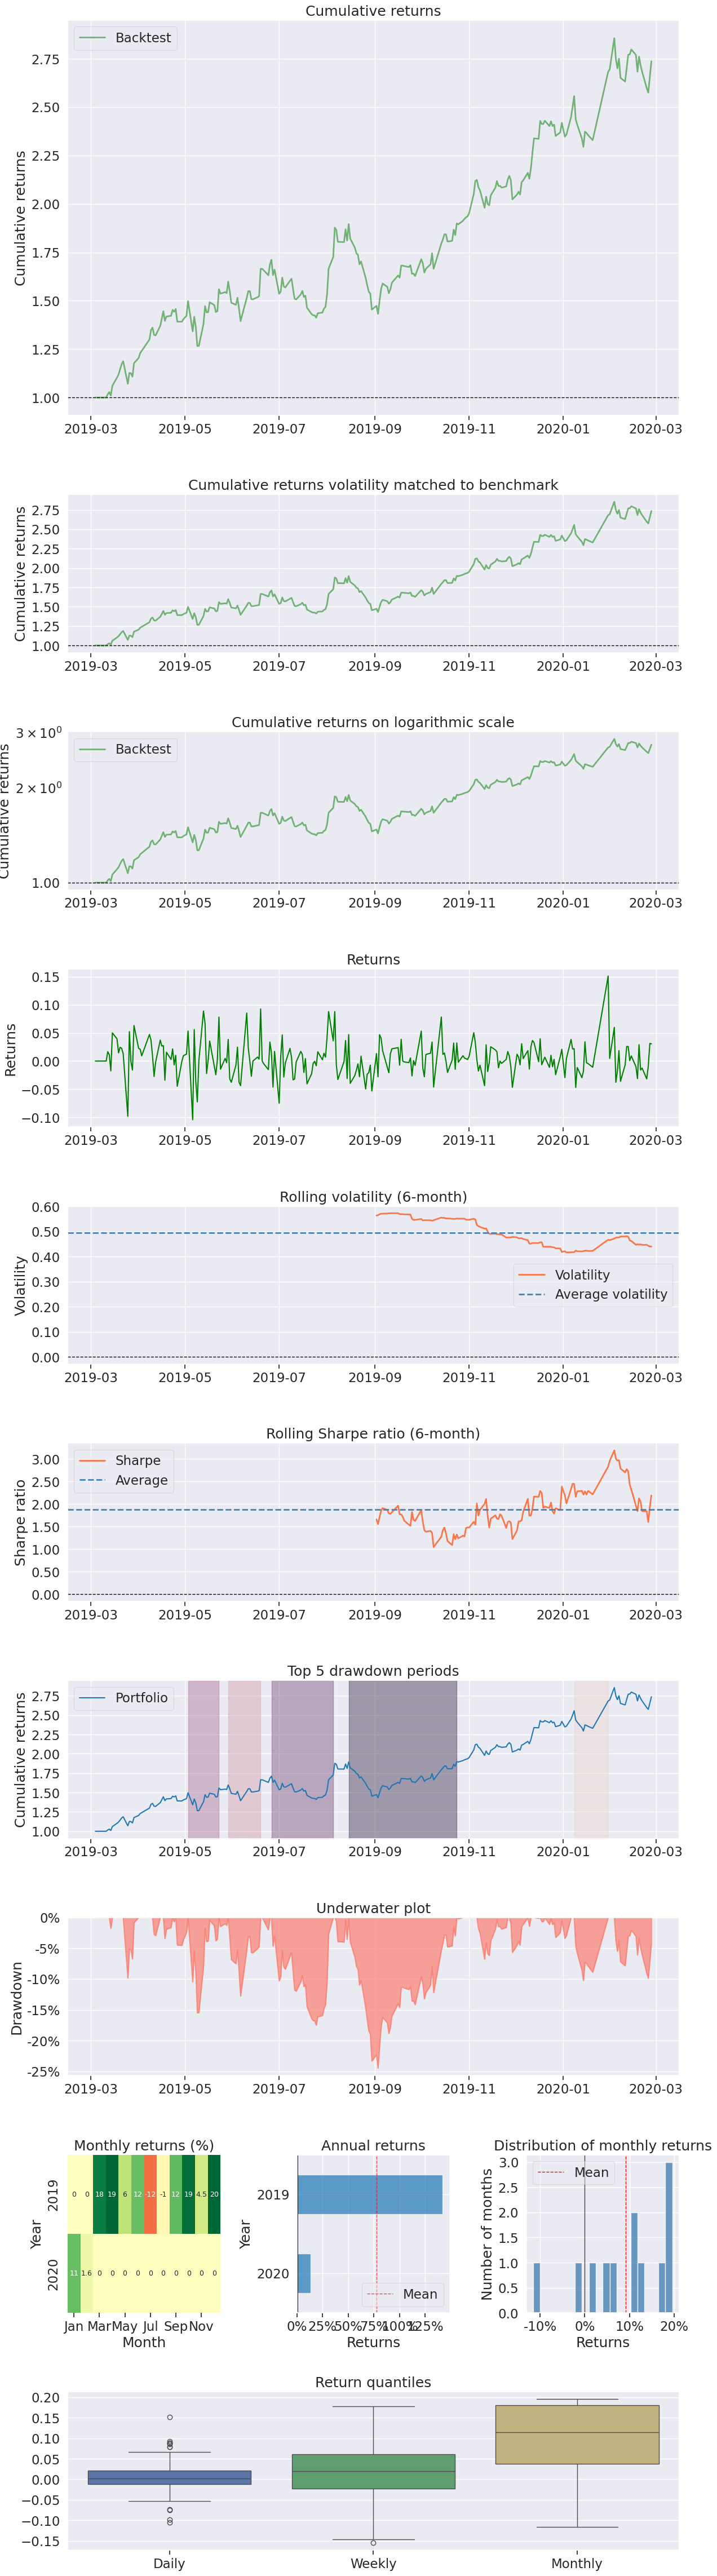

In [8]:
# 產生回測報告
pf.create_returns_tear_sheet(returns, positions=positions)
print(f'累積收益: {ep.cum_returns_final(returns)}')
print(f'最大回撤: {ep.max_drawdown(returns)}')
print(f'夏普比率: {ep.sharpe_ratio(returns)}')

初始資產價值: 300000.00
2019-03-12T09:45:00, 創建買單
2019-03-12T10:15:00, BUY EXECUTED, Price: 10359.00, 
                         Cost: 167000.00, 
                         Comm 200.00
2019-03-20T13:15:00, Expired and Create Close Order
2019-03-20T13:45:00, SELL EXECUTED, Price: 10543.00,
                          Cost: 167000.00, 
                          Comm 200.00
2019-03-20T13:45:00, OPERATION PROFIT, GROSS 36800.00, NET 36400.00
2019-03-21T09:45:00, 創建買單
2019-03-21T10:15:00, BUY EXECUTED, Price: 10549.00, 
                         Cost: 167000.00, 
                         Comm 200.00
2019-04-08T09:45:00, 平多單 - 停利
2019-04-08T10:15:00, SELL EXECUTED, Price: 10785.00,
                          Cost: 167000.00, 
                          Comm 200.00
2019-04-08T10:15:00, OPERATION PROFIT, GROSS 47200.00, NET 46800.00
2019-04-08T10:15:00, 創建買單
2019-04-08T10:45:00, BUY EXECUTED, Price: 10772.00, 
                         Cost: 167000.00, 
                         Comm 200.00
2019-04-17T10:45:

Start date,2019-03-04
End date,2020-02-27
Total months,11
,Backtest
Annual return,129.868%
Cumulative returns,122.4%
Annual volatility,52.198%
Sharpe ratio,1.85
Calmar ratio,4.72
Stability,0.88
Max drawdown,-27.528%


Worst drawdown periods,Net drawdown in %,Peak date,Valley date,Recovery date,Duration
0,27.53,2020-02-03,2020-02-25,NaT,NaN
1,24.40,2019-08-15,2019-09-03,2019-10-22,49
2,17.79,2019-06-26,2019-07-25,2019-08-06,30
3,16.55,2019-05-03,2019-05-09,2019-05-23,15
4,11.00,2019-05-29,2019-06-06,2019-06-19,16


累積收益: 1.223999999999998
最大回撤: -0.27528355387523606
夏普比率: 1.8546412114518773


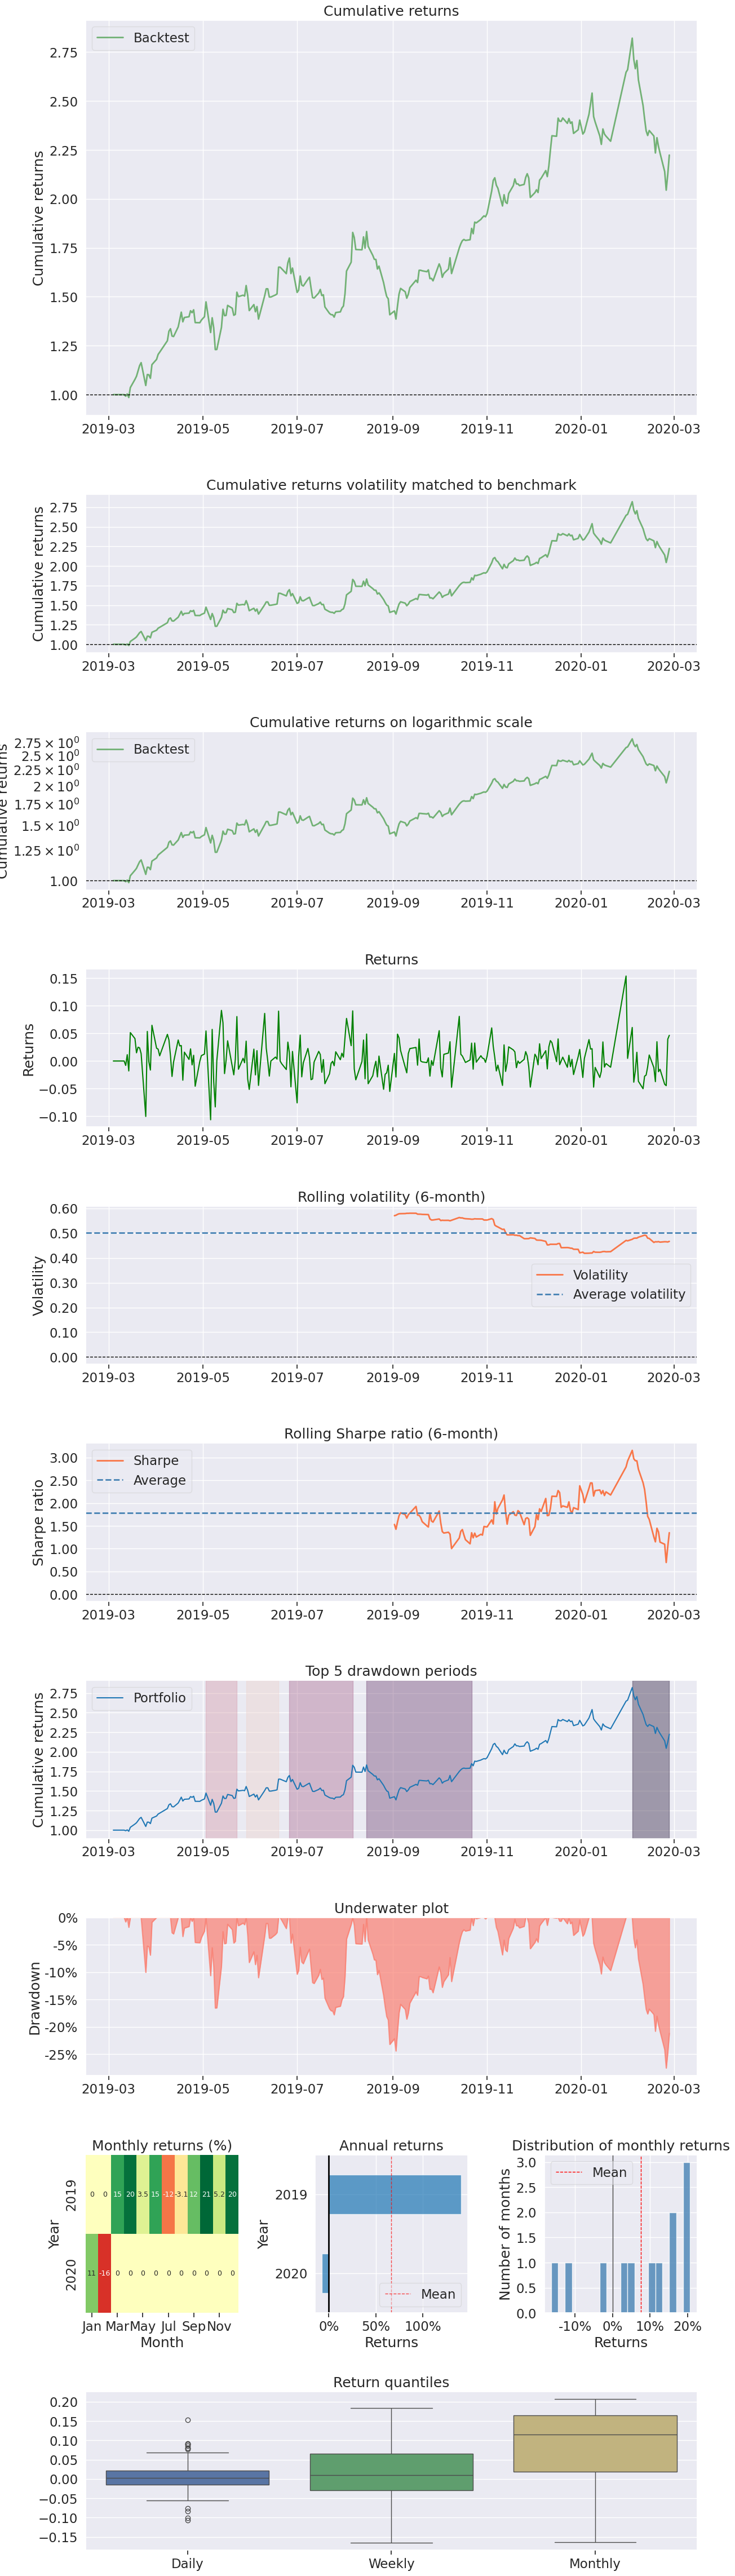

In [9]:
#%%
import datetime  
import backtrader as bt
import pandas as pd
import calendar
from datetime import datetime 
import empyrical as ep
import pyfolio as pf
import warnings
warnings.filterwarnings('ignore')

def option_expiration(date): 
    day = 21 - (calendar.weekday(date.year, date.month, 1) + 4) % 7 
    return datetime(date.year, date.month, day) 

class MA_Volume_Strategy(bt.Strategy):
    params = (
        ('ma_short', 5),
        ('ma_medium', 20),
        ('ma_long', 60),
        ('stop_loss_pct', 0.02),  
        ('take_profit_pct', 0.02), 
    )

    def log(self, txt, dt=None):
        ''' 日誌記錄函數 '''
        dt = dt or self.datas[0].datetime.datetime(0)
        print(f'{dt.isoformat()}, {txt}')

    def __init__(self):
        # 收盤價
        self.dataclose = self.datas[0].close

        # 成交量
        self.datavolume = self.datas[0].volume

        # 移動平均線
        self.ma_short = bt.indicators.SMA(self.dataclose, period=self.params.ma_short)
        self.ma_medium = bt.indicators.SMA(self.dataclose, period=self.params.ma_medium)
        self.ma_long = bt.indicators.SMA(self.dataclose, period=self.params.ma_long)

        # 成交量移動平均線
        self.vol_ma_short = bt.indicators.SMA(self.datavolume, period=self.params.ma_short)
        self.vol_ma_long = bt.indicators.SMA(self.datavolume, period=self.params.ma_long)

        self.order = None

    def notify_order(self, order):
        if order.status in [order.Submitted, order.Accepted]:
            return
        if order.status in [order.Completed]:
            if order.isbuy():
                self.log(f'''BUY EXECUTED, Price: {order.executed.price:.2f}, 
                         Cost: {order.executed.value:.2f}, 
                         Comm {order.executed.comm:.2f}''')
                self.buycomm = order.executed.comm
            else:
                self.sellprice = order.executed.price
                self.log(f'''SELL EXECUTED, Price: {order.executed.price:.2f},
                          Cost: {order.executed.value:.2f}, 
                          Comm {order.executed.comm:.2f}''')
            self.bar_executed = len(self)
        self.order = None

    def notify_trade(self, trade):
        if not trade.isclosed:
            return
        self.log(f'OPERATION PROFIT, GROSS {trade.pnl:.2f}, NET {trade.pnlcomm:.2f}')

    def next(self):
        if self.order:
            return

        position_size = self.getposition().size
        position_price = self.getposition().price

        status = None
        if (
            option_expiration(self.datas[0].datetime.datetime(0)).day
            == self.datas[0].datetime.datetime(0).day
        ):
            if self.datas[0].datetime.datetime(0).hour >= 13:
                status = "end"
                if  position_size != 0:
                    self.close()
                    self.log("Expired and Create Close Order")

        if status != 'end':
            if not position_size:
                # 多頭進場條件
                if (self.dataclose[0] > self.ma_short[0] and
                    self.dataclose[0] > self.ma_medium[0] and
                    self.dataclose[0] > self.ma_long[0] and
                    self.vol_ma_short[0] > self.vol_ma_long[0]):
                    self.order = self.buy()
                    self.log('創建買單')
                # 空頭進場條件
                elif (self.dataclose[0] < self.ma_short[0] and
                    self.dataclose[0] < self.ma_medium[0] and
                    self.dataclose[0] < self.ma_long[0] and
                    self.vol_ma_short[0] < self.vol_ma_long[0]):
                    self.order = self.sell()
                    self.log('創建賣單')
            else:
                # 已有持倉，檢查出場條件
                if position_size > 0:
                    stop_loss_price = position_price * (1 - self.params.stop_loss_pct)
                    take_profit_price = position_price * (1 + self.params.take_profit_pct)
                    # 多頭持倉
                    if self.dataclose[0] >= take_profit_price:
                        self.order = self.close()
                        self.log('平多單 - 停利')
                    elif self.dataclose[0] <= stop_loss_price:
                        self.order = self.close()
                        self.log('平多單 - 停損')

                elif position_size < 0:
                    stop_loss_price = position_price * (1 + self.params.stop_loss_pct)
                    take_profit_price = position_price * (1 - self.params.take_profit_pct)
                    # 空頭持倉
                    if self.dataclose[0] <= take_profit_price:
                        self.order = self.close()
                        self.log('平空單 - 停利')
                    elif self.dataclose[0] >= stop_loss_price:
                        self.order = self.close()
                        self.log('平空單 - 停損')

# 初始化 Cerebro 引擎
cerebro = bt.Cerebro()
df = pd.read_csv('TXF_30.csv')
df = df.dropna()
df['Date'] = pd.to_datetime(df['Date'])
df.index = df['Date']
df = df.between_time('08:45', '13:45')
data_feed = bt.feeds.PandasData(
    dataname=df,
    name='TXF',
    datetime=0,
    high=2,
    low=3,
    open=1,
    close=4,
    volume=5,
    plot=False,
)
cerebro.adddata(data_feed, name='TXF')

# 添加策略
cerebro.addstrategy(MA_Volume_Strategy)

# 設定初始資金和交易成本
cerebro.broker.setcash(300000.0)
cerebro.broker.setcommission(commission=200, margin=167000, mult=200)

print('初始資產價值: %.2f' % cerebro.broker.getvalue())
cerebro.addanalyzer(bt.analyzers.PyFolio, _name='pyfolio')

# 執行回測
results = cerebro.run()

print('最終資產價值: %.2f' % cerebro.broker.getvalue())

# 獲取回測結果
strat = results[0]
pyfoliozer = strat.analyzers.getbyname('pyfolio')
returns, positions, transactions, gross_lev = pyfoliozer.get_pf_items()

# 生成回測報告
pf.create_returns_tear_sheet(returns, positions=positions)
print('累積收益:', ep.cum_returns_final(returns))
print('最大回撤:', ep.max_drawdown(returns))
print('夏普比率:', ep.sharpe_ratio(returns))
# %%